In [8]:
from sklearn.linear_model import SGDRegressor
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

In [9]:
df = pd.read_csv("train.csv",engine='c',memory_map=True)

In [10]:
#Normalement il faudrait traiter les données numériques pour vérifier qu'il n'y ait pas de valeurs manquantes. En pratique ça fait 1 Million de fois que je fais ça, j'ai déjà vérifié et il n'y a pas de valeurs manquantes

# On sauvegarde la colonne pickup_datetime
pickupDatetime  = pd.to_datetime(df.pickup_datetime)
dropoffDatetime = pd.to_datetime(df.dropoff_datetime)

# On supprime toutes les colonnes potentiellement innutiles, on en garde beaucoup plus que la dernière fois car je vais remplacer les valeurs non numérique par des valeurs numériques. Seul l'id finit par sauter car les temps de trajet varient en fonction du vendor_id, on supprime ici les colonnes de datetime, mais leurs informations seront remises par la suite
finalDF = df.drop(['id','pickup_datetime','dropoff_datetime'],axis=1)

# On sépare les données en deux : les données qui seront en entrée de l'algorithme (X) et les données en sortie (Y)
X = finalDF.loc[:,finalDF.columns != 'trip_duration']
Y = finalDF.trip_duration

# On reccréer des colonnes de pickup en séparant les informations de la date
X['pickupHour'] = pickupDatetime.dt.hour
X['pickupMinute'] = pickupDatetime.dt.minute
X['pickupSecond'] = pickupDatetime.dt.second
X['pickupDayOfWeek'] = pickupDatetime.dt.dayofweek
X['pickupWeekOfYear'] = pickupDatetime.dt.weekofyear
X['pickupDayOfYear'] = pickupDatetime.dt.dayofyear

# Pareil pour le dropoff
X['dropoffHour'] = dropoffDatetime.dt.hour
X['dropoffMinute'] = dropoffDatetime.dt.minute
X['dropoffSecond'] = dropoffDatetime.dt.second
X['dropoffDayOfWeek'] = dropoffDatetime.dt.dayofweek
X['dropoffWeekOfYear'] = dropoffDatetime.dt.weekofyear
X['dropoffDayOfYear'] = dropoffDatetime.dt.dayofyear

# J'ajoute à la fin la distance haversine (voir linearRegression.ipynb)
def heversine (lat1, lat2, lng1, lng2):
    lat1, lat2, lng1, lng2 = map(np.radians, (lat1, lat2, lng1, lng2))
    AVERAGE_EARTH_RADIUS = 6371#km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVERAGE_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

# Par une magie inconnue df.loc[:, <nom de colonne>] créée une autre colonne donc je créé une colonne avec les distances
X['distance_haversine'] = heversine(df.pickup_latitude.values, df.dropoff_latitude.values, df.pickup_longitude.values, df.dropoff_longitude.values)

In [11]:
# On utilise une classe sklearn qui permet de remplacer les données non numériques par des valeurs numériques afin de pouvoir les exploiter dans le modèle d'apprentissage. Ce que l'on va utiliser pour ça c'est une méthode qui va créer autant de colonnes qu'il y a de valeurs différentes, et mettre un 1 pour chaque ligne qui contient la valeur de la colonne et 0 dans les autres (ça se comprend en 1/2s avec une image https://www.kaggle.com/alexisbcook/categorical-variables).

# Tout d'abord on affiche les colonnes qui ont un type 'object'. On voit qu'il n'y a que store_and_fwd_flag
print(X.dtypes == 'object')

vendor_id             False
passenger_count       False
pickup_longitude      False
pickup_latitude       False
dropoff_longitude     False
dropoff_latitude      False
store_and_fwd_flag     True
pickupHour            False
pickupMinute          False
pickupSecond          False
pickupDayOfWeek       False
pickupWeekOfYear      False
pickupDayOfYear       False
dropoffHour           False
dropoffMinute         False
dropoffSecond         False
dropoffDayOfWeek      False
dropoffWeekOfYear     False
dropoffDayOfYear      False
distance_haversine    False
dtype: bool


In [12]:
# Ensuite on regarde combien de valeur différentes il y a dans cette colonne. Le site du défi sur Kaggle nous dit qu'il n'y a que N et Y mais ça ne fait pas de mal de vérifier ça en python
print(X.store_and_fwd_flag.unique())

['N' 'Y']


In [13]:
# La méthode que l'on va utiliser s'appelle OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
OHEncoder = OneHotEncoder(sparse=False)

# Création de l'encodage
OHEncodedColumn = pd.DataFrame(OHEncoder.fit_transform(X[['store_and_fwd_flag']]))
# En principe, l'OHEncoder supprime les index et il faudrait les remettres. Ici les index étant juste le numéro de la ligne ils sont là par défaut et il n'y a donc pas besoin de cette étape

In [14]:
# On supprime des données la colonne qui a été encodées
XSupp = X.drop('store_and_fwd_flag', axis=1)

# On ajoute les données encodées
XFinal = pd.concat([XSupp, OHEncodedColumn], axis=1)
YFinal = Y # Juste pour la cohérence des noms

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
XTrain, XTest, YTrain, YTest = train_test_split(X,Y,train_size=0.90,random_state=19061996)


In [42]:
XFinalPolynomial = PolynomialFeatures(2).fit_transform(XFinal[['distance_haversine']])

In [52]:
# Descente du gradient en utilisant que la distance
model = SGDRegressor().fit(XFinal,YFinal)

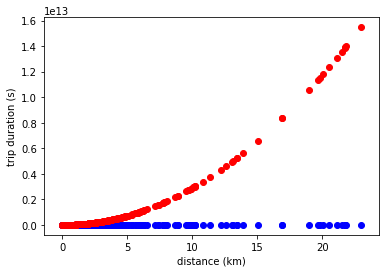

In [59]:
XTestPolynomial = PolynomialFeatures(2).fit_transform(XTest[['distance_haversine']])
plt.scatter(XTest.distance_haversine[:400],YTest[:400],c='blue')
plt.scatter(XTest.distance_haversine[:400],model.predict(XTestPolynomial[:400]),c='red')
plt.xlabel('distance (km)')
plt.ylabel('trip duration (s)')
plt.show()

In [61]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(YTest, model.predict(XTestPolynomial)))

850680749547.9708
